In [1]:
from jax import grad, jit, vmap, pmap
from jax import random
from typing import NamedTuple, Tuple
from jax.scipy.special import logsumexp
from functools import partial
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import nvidia_smi

In [ ]:
jax.devices()

In [4]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

In [5]:
layer_sizes = [784, 512, 10]
num_epochs = 50
step_size = 0.01
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHANNELS = 1
BATCH_SIZE = 32
CLASS_NAMES = [str(item) for item in range(10)]
N_DEVICES = jax.local_device_count()

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
def decode_img(img, img_channel=3, img_height=224, img_width=224):
    img = tf.image.decode_jpeg(img, channels=img_channel)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [img_height, img_width])

In [7]:
def parse_file(file_pattern, class_names=CLASS_NAMES, separator=" "):
    file_path = tf.strings.split(file_pattern, separator)
    img = tf.io.read_file(file_path[0])
    img = decode_img(img, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)
    label = file_path[1]
    one_hot = label == class_names
    
    return img, tf.cast(one_hot, tf.int32)

In [8]:
def transform_batch(x , y, n_devices, batch_size):
    x = tf.reshape(x, shape=(n_devices, batch_size, -1))
    y = tf.reshape(y, shape=(n_devices, batch_size, -1))
    return x, y

In [9]:
def pipeline_transform(dataset):
    parse_image = partial(parse_file, class_names=CLASS_NAMES, separator=" ")
    batch_trans = partial(transform_batch, n_devices=N_DEVICES, batch_size=BATCH_SIZE)
    dataset = (dataset
          .map(parse_image, num_parallel_calls=AUTOTUNE)
          .cache()
          .batch(N_DEVICES*BATCH_SIZE, drop_remainder=True)
          .map(batch_trans, num_parallel_calls=AUTOTUNE)
          .prefetch(buffer_size=AUTOTUNE)
    )
    
    return dataset

In [10]:
def get_dataset(val_percentage=0.2):
    gcs_prefix = "gs://xxxx/dataset/" # Replace the google storage URL here
    train_files = tf.io.gfile.GFile(os.path.join(gcs_prefix, "mnist", "train.txt"))
    train_files = [file.strip() for file in train_files]
    test_files = tf.io.gfile.GFile(os.path.join(gcs_prefix, "mnist", "test.txt"))
    test_files = [file.strip() for file in test_files]
    
    train_ds = tf.data.Dataset.from_tensor_slices(train_files)
    test_ds = tf.data.Dataset.from_tensor_slices(test_files)
    
    train_ds = train_ds.shuffle(len(train_files), reshuffle_each_iteration=False)
    val_size = int(len(train_files) * val_percentage)
    val_ds = train_ds.take(val_size)
    train_ds = train_ds.skip(val_size)

    print(f"Train dataset size: {tf.data.experimental.cardinality(train_ds).numpy()}")
    print(f"Val dataset size: {tf.data.experimental.cardinality(val_ds).numpy()}")
    print(f"Test dataset size: {tf.data.experimental.cardinality(test_ds).numpy()}")
    
    train_ds = pipeline_transform(train_ds)
    val_ds = pipeline_transform(val_ds)
    test_ds = pipeline_transform(test_ds)
    
    return tfds.as_numpy(train_ds), tfds.as_numpy(val_ds), tfds.as_numpy(test_ds)

In [18]:
class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray

def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return Params(scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,)))

def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

@jit
def relu(x):
    return jnp.maximum(0, x)

@jit
def predict(params, image):
    activations = image
    *hidden, last = params
    for layer in hidden:
        outputs = jnp.dot(activations, layer.weight) + layer.bias
        activations = relu(outputs)
    logits = jnp.dot(activations, last.weight) + last.bias

    return logits - logsumexp(logits)

def one_hot(x, k, dtype=np.float32):
    return np.array(x[:, None] == np.arange(k), dtype)

@partial(jax.pmap, axis_name="num_devices")
def p_accuracy(params, images, targets):
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, images), axis=1)
    return jax.lax.pmean(predicted_class == target_class, axis_name="num_devices")

@jit
def loss_func(params, images, targets):
    preds = predict(params, images)
    return -jnp.mean(preds * targets)

@partial(jax.pmap, axis_name="num_devices")
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Tuple[Params, jnp.ndarray]:
    loss, grads = jax.value_and_grad(loss_func)(params, x, y)

    grads = jax.lax.pmean(grads, axis_name="num_devices")
    loss = jax.lax.pmean(loss, axis_name="num_devices")

    new_params = jax.tree_multimap(
        lambda param, g: param - g * step_size, params, grads
    )

    return new_params, loss


In [19]:
import GPUtil
from threading import Thread
import time
import matplotlib.pyplot as plt

class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay
        self.gpu_usage = {}

    def run(self):
        while not self.stopped:
            for i, res in enumerate(GPUtil.getGPUs()):
                if i in self.gpu_usage:
                    self.gpu_usage[i].append(res.load * 100)
                else:
                    self.gpu_usage[i] = []
            
            time.sleep(self.delay)

    def stop_record(self):
        self.stopped = True
    
    def start_record(self):
        self.start()
        
    def get_gpu_usage(self):
        return self.gpu_usage
    
    def plot_gpu_usage(self):
        for i in self.gpu_usage.keys():
            plt.plot(range(len(self.gpu_usage[i])), self.gpu_usage[i], label=f"gpu_{i}")
        plt.xlabel("seconds")
        plt.ylabel("GPU load in percentage")
        plt.title("GPU load during training process")
        plt.legend()
        plt.show()

In [20]:
import time

def train():
    train_losses = []
    train_accs = []
    val_accs = []
    train_times = []
    params = init_network_params(layer_sizes, random.PRNGKey(0))
    replicated_params = jax.tree_map(lambda x: jnp.array([x] * N_DEVICES), params)
    train_ds, val_ds, _ = get_dataset()
    
    monitor.start_record()
    for epoch in range(num_epochs):
        train_batch_acc = []
        val_batch_acc = []
        start_time = time.time()

        for x_batch, y_batch in train_ds:
            replicated_params, loss = update(replicated_params, x_batch, y_batch)
            batch_acc = jax.device_get(
                jax.tree_map(lambda x: x[0], 
                p_accuracy(replicated_params, x_batch, y_batch)))
            train_batch_acc.append(batch_acc)


        for x_val, y_val in val_ds:
            val_batch_acc.append(jax.device_get(
                jax.tree_map(lambda x: x[0], 
                p_accuracy(replicated_params, x_val, y_val))))
        epoch_time = time.time() - start_time

        params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))
        loss = jax.device_get(jax.tree_map(lambda x: x[0], loss))
        train_acc = jnp.mean(jnp.asarray(train_batch_acc))
        val_acc = jnp.mean(jnp.asarray(val_batch_acc))
        train_losses.append(loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_times.append(epoch_time)
        
        print("Epoch {}/{} in {:0.2f} secs | Loss: {:0.4f} | Train Acc: {:0.4f} | Test Acc: {:0.4f}".format(
            epoch + 1,
            num_epochs,
            epoch_time,
            loss,
            train_acc,
            val_acc
            ))
    monitor.stop_record()
    plot_mnist_performance(train_losses, train_accs, val_accs, train_times, monitor, sup_title="MNIST Classification")
    print(f"Total avg time per epoch : {np.mean(train_times)}")


# MNIST with 1 GPUs, vCPU 16

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 5.56 secs | Loss: 0.5662 | Train Acc: 0.5286 | Test Acc: 0.6335
Epoch 2/50 in 2.47 secs | Loss: 0.5402 | Train Acc: 0.6483 | Test Acc: 0.6487
Epoch 3/50 in 2.50 secs | Loss: 0.5000 | Train Acc: 0.6826 | Test Acc: 0.7090
Epoch 4/50 in 2.63 secs | Loss: 0.4687 | Train Acc: 0.7435 | Test Acc: 0.7765
Epoch 5/50 in 2.62 secs | Loss: 0.4522 | Train Acc: 0.7959 | Test Acc: 0.8094
Epoch 6/50 in 2.53 secs | Loss: 0.4406 | Train Acc: 0.8215 | Test Acc: 0.8292
Epoch 7/50 in 2.78 secs | Loss: 0.4308 | Train Acc: 0.8372 | Test Acc: 0.8412
Epoch 8/50 in 2.57 secs | Loss: 0.4225 | Train Acc: 0.8481 | Test Acc: 0.8512
Epoch 9/50 in 2.68 secs | Loss: 0.4158 | Train Acc: 0.8567 | Test Acc: 0.8607
Epoch 10/50 in 2.53 secs | Loss: 0.4104 | Train Acc: 0.8635 | Test Acc: 0.8659
Epoch 11/50 in 2.65 secs | Loss: 0.4061 | Train Acc: 0.8691 | Test Acc: 0.8714
Epoch 12/50 in 2.50 secs | Loss: 0.4025 | Train Acc: 0.8734 | Tes

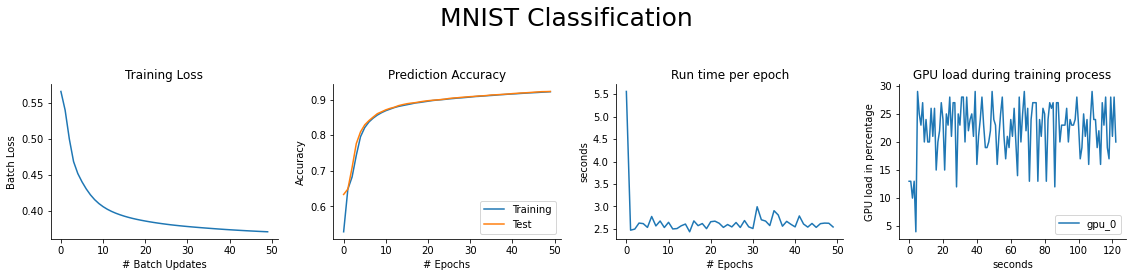

In [45]:
BATCH_SIZE = 32
monitor = Monitor(1)
train()

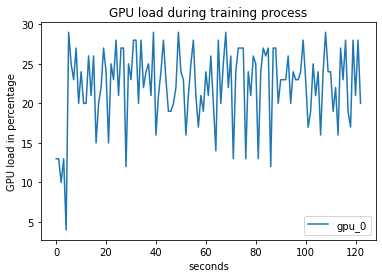

In [46]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 5.53 secs | Loss: 0.6425 | Train Acc: 0.4257 | Test Acc: 0.5975
Epoch 2/50 in 1.29 secs | Loss: 0.6375 | Train Acc: 0.6411 | Test Acc: 0.6550
Epoch 3/50 in 1.29 secs | Loss: 0.6296 | Train Acc: 0.6609 | Test Acc: 0.6593
Epoch 4/50 in 1.29 secs | Loss: 0.6173 | Train Acc: 0.6670 | Test Acc: 0.6700
Epoch 5/50 in 1.34 secs | Loss: 0.6005 | Train Acc: 0.6829 | Test Acc: 0.6917
Epoch 6/50 in 1.32 secs | Loss: 0.5806 | Train Acc: 0.7063 | Test Acc: 0.7147
Epoch 7/50 in 1.28 secs | Loss: 0.5609 | Train Acc: 0.7331 | Test Acc: 0.7477
Epoch 8/50 in 1.30 secs | Loss: 0.5444 | Train Acc: 0.7641 | Test Acc: 0.7767
Epoch 9/50 in 1.30 secs | Loss: 0.5321 | Train Acc: 0.7898 | Test Acc: 0.7948
Epoch 10/50 in 1.34 secs | Loss: 0.5232 | Train Acc: 0.8060 | Test Acc: 0.8093
Epoch 11/50 in 1.27 secs | Loss: 0.5164 | Train Acc: 0.8181 | Test Acc: 0.8201
Epoch 12/50 in 1.28 secs | Loss: 0.5111 | Train Acc: 0.8277 | Tes

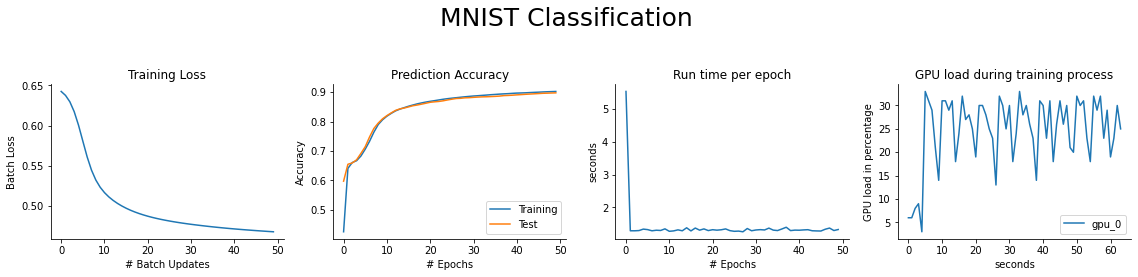

In [47]:
BATCH_SIZE = 64
monitor = Monitor(1)
train()

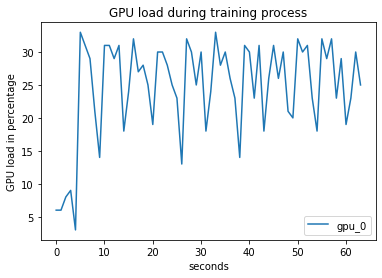

In [48]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 4.85 secs | Loss: 0.8535 | Train Acc: 0.1503 | Test Acc: 0.1973
Epoch 2/50 in 0.28 secs | Loss: 0.8531 | Train Acc: 0.2423 | Test Acc: 0.2931
Epoch 3/50 in 0.33 secs | Loss: 0.8526 | Train Acc: 0.3383 | Test Acc: 0.3792
Epoch 4/50 in 0.26 secs | Loss: 0.8522 | Train Acc: 0.4213 | Test Acc: 0.4502
Epoch 5/50 in 0.26 secs | Loss: 0.8518 | Train Acc: 0.4890 | Test Acc: 0.5053
Epoch 6/50 in 0.26 secs | Loss: 0.8513 | Train Acc: 0.5335 | Test Acc: 0.5437
Epoch 7/50 in 0.34 secs | Loss: 0.8508 | Train Acc: 0.5650 | Test Acc: 0.5708
Epoch 8/50 in 0.26 secs | Loss: 0.8503 | Train Acc: 0.5867 | Test Acc: 0.5889
Epoch 9/50 in 0.25 secs | Loss: 0.8497 | Train Acc: 0.6043 | Test Acc: 0.6033
Epoch 10/50 in 0.25 secs | Loss: 0.8492 | Train Acc: 0.6169 | Test Acc: 0.6151
Epoch 11/50 in 0.33 secs | Loss: 0.8486 | Train Acc: 0.6280 | Test Acc: 0.6245
Epoch 12/50 in 0.24 secs | Loss: 0.8480 | Train Acc: 0.6356 | Tes

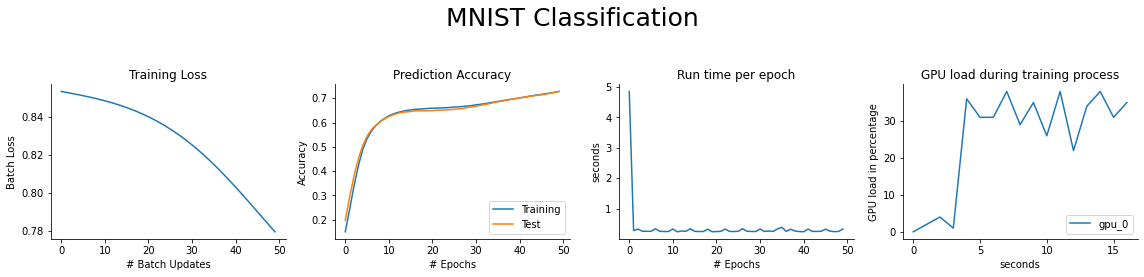

In [49]:
BATCH_SIZE = 512
monitor = Monitor(1)
train()

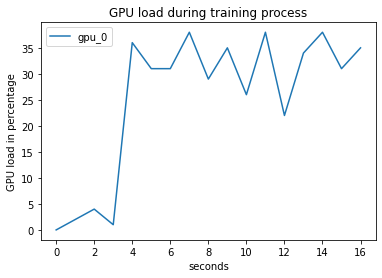

In [50]:
monitor.plot_gpu_usage()

# MNIST with 1 GPUs, vCPU 16

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 33.72 secs | Loss: 0.5672 | Train Acc: 0.5219 | Test Acc: 0.6507
Epoch 2/50 in 2.35 secs | Loss: 0.5443 | Train Acc: 0.6565 | Test Acc: 0.6722
Epoch 3/50 in 2.29 secs | Loss: 0.5017 | Train Acc: 0.6925 | Test Acc: 0.7221
Epoch 4/50 in 2.30 secs | Loss: 0.4632 | Train Acc: 0.7465 | Test Acc: 0.7779
Epoch 5/50 in 2.25 secs | Loss: 0.4456 | Train Acc: 0.7971 | Test Acc: 0.8069
Epoch 6/50 in 2.22 secs | Loss: 0.4382 | Train Acc: 0.8225 | Test Acc: 0.8266
Epoch 7/50 in 2.23 secs | Loss: 0.4333 | Train Acc: 0.8379 | Test Acc: 0.8403
Epoch 8/50 in 2.27 secs | Loss: 0.4290 | Train Acc: 0.8486 | Test Acc: 0.8510
Epoch 9/50 in 2.27 secs | Loss: 0.4251 | Train Acc: 0.8574 | Test Acc: 0.8582
Epoch 10/50 in 2.30 secs | Loss: 0.4217 | Train Acc: 0.8637 | Test Acc: 0.8633
Epoch 11/50 in 2.44 secs | Loss: 0.4186 | Train Acc: 0.8692 | Test Acc: 0.8683
Epoch 12/50 in 2.43 secs | Loss: 0.4160 | Train Acc: 0.8738 | Te

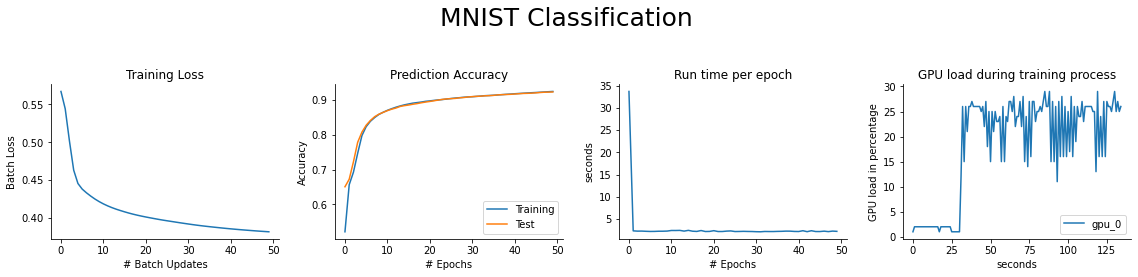

In [16]:
# (First time access on storage from different location)
BATCH_SIZE = 32
monitor = Monitor(1)
train()

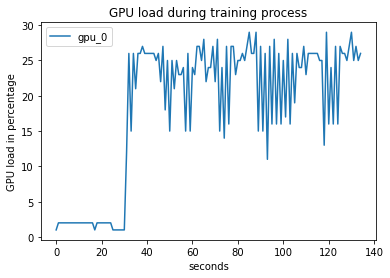

In [17]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 3.03 secs | Loss: 0.5694 | Train Acc: 0.5319 | Test Acc: 0.6724
Epoch 2/50 in 2.11 secs | Loss: 0.5514 | Train Acc: 0.6697 | Test Acc: 0.6855
Epoch 3/50 in 2.15 secs | Loss: 0.5175 | Train Acc: 0.6968 | Test Acc: 0.7249
Epoch 4/50 in 2.30 secs | Loss: 0.4839 | Train Acc: 0.7486 | Test Acc: 0.7850
Epoch 5/50 in 2.10 secs | Loss: 0.4632 | Train Acc: 0.7955 | Test Acc: 0.8150
Epoch 6/50 in 2.12 secs | Loss: 0.4508 | Train Acc: 0.8225 | Test Acc: 0.8332
Epoch 7/50 in 2.10 secs | Loss: 0.4427 | Train Acc: 0.8382 | Test Acc: 0.8456
Epoch 8/50 in 2.27 secs | Loss: 0.4372 | Train Acc: 0.8487 | Test Acc: 0.8553
Epoch 9/50 in 2.10 secs | Loss: 0.4335 | Train Acc: 0.8571 | Test Acc: 0.8631
Epoch 10/50 in 2.20 secs | Loss: 0.4310 | Train Acc: 0.8634 | Test Acc: 0.8680
Epoch 11/50 in 2.06 secs | Loss: 0.4292 | Train Acc: 0.8692 | Test Acc: 0.8727
Epoch 12/50 in 2.08 secs | Loss: 0.4278 | Train Acc: 0.8736 | Tes

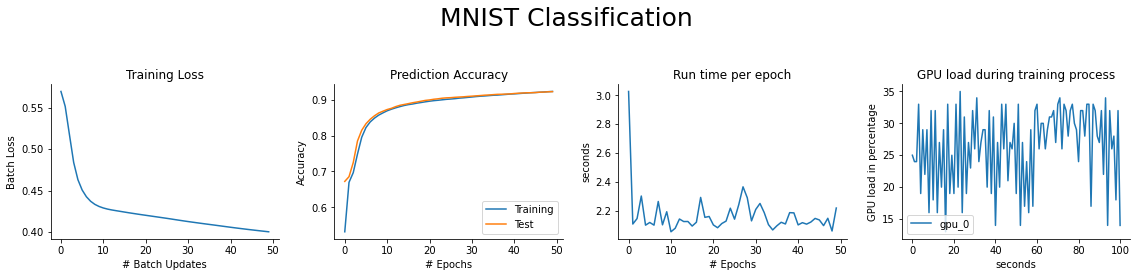

In [17]:
BATCH_SIZE = 32
monitor = Monitor(1)
train()

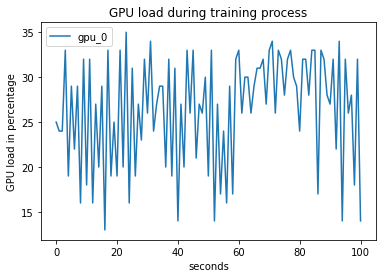

In [18]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 3.02 secs | Loss: 0.6426 | Train Acc: 0.4219 | Test Acc: 0.6025
Epoch 2/50 in 1.30 secs | Loss: 0.6375 | Train Acc: 0.6361 | Test Acc: 0.6511
Epoch 3/50 in 1.29 secs | Loss: 0.6294 | Train Acc: 0.6545 | Test Acc: 0.6562
Epoch 4/50 in 1.26 secs | Loss: 0.6172 | Train Acc: 0.6612 | Test Acc: 0.6666
Epoch 5/50 in 1.25 secs | Loss: 0.6006 | Train Acc: 0.6808 | Test Acc: 0.6898
Epoch 6/50 in 1.21 secs | Loss: 0.5812 | Train Acc: 0.7039 | Test Acc: 0.7152
Epoch 7/50 in 1.20 secs | Loss: 0.5623 | Train Acc: 0.7312 | Test Acc: 0.7482
Epoch 8/50 in 1.20 secs | Loss: 0.5468 | Train Acc: 0.7631 | Test Acc: 0.7771
Epoch 9/50 in 1.24 secs | Loss: 0.5356 | Train Acc: 0.7872 | Test Acc: 0.7997
Epoch 10/50 in 1.24 secs | Loss: 0.5277 | Train Acc: 0.8036 | Test Acc: 0.8116
Epoch 11/50 in 1.26 secs | Loss: 0.5218 | Train Acc: 0.8163 | Test Acc: 0.8221
Epoch 12/50 in 1.13 secs | Loss: 0.5171 | Train Acc: 0.8260 | Tes

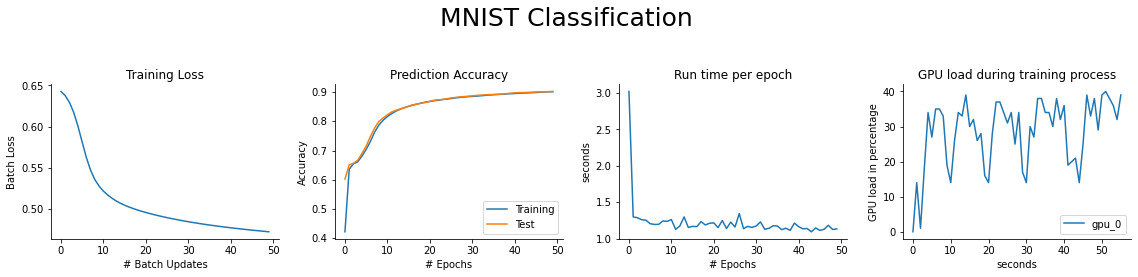

In [18]:
BATCH_SIZE = 64
monitor = Monitor(1)
train()

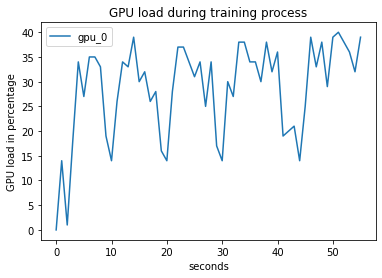

In [19]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 2.54 secs | Loss: 0.8535 | Train Acc: 0.1510 | Test Acc: 0.1908
Epoch 2/50 in 0.27 secs | Loss: 0.8531 | Train Acc: 0.2445 | Test Acc: 0.2933
Epoch 3/50 in 0.38 secs | Loss: 0.8527 | Train Acc: 0.3397 | Test Acc: 0.3801
Epoch 4/50 in 0.25 secs | Loss: 0.8522 | Train Acc: 0.4247 | Test Acc: 0.4576
Epoch 5/50 in 0.25 secs | Loss: 0.8518 | Train Acc: 0.4925 | Test Acc: 0.5160
Epoch 6/50 in 0.25 secs | Loss: 0.8514 | Train Acc: 0.5387 | Test Acc: 0.5520
Epoch 7/50 in 0.37 secs | Loss: 0.8509 | Train Acc: 0.5710 | Test Acc: 0.5795
Epoch 8/50 in 0.24 secs | Loss: 0.8504 | Train Acc: 0.5934 | Test Acc: 0.6037
Epoch 9/50 in 0.25 secs | Loss: 0.8499 | Train Acc: 0.6115 | Test Acc: 0.6194
Epoch 10/50 in 0.24 secs | Loss: 0.8494 | Train Acc: 0.6244 | Test Acc: 0.6292
Epoch 11/50 in 0.36 secs | Loss: 0.8488 | Train Acc: 0.6337 | Test Acc: 0.6384
Epoch 12/50 in 0.24 secs | Loss: 0.8482 | Train Acc: 0.6415 | Tes

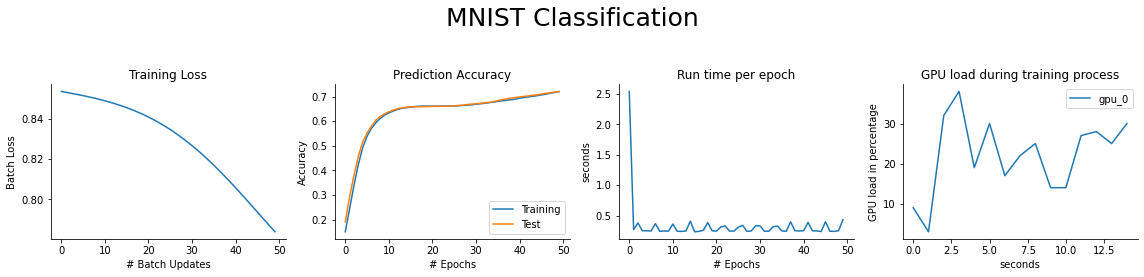

In [20]:
BATCH_SIZE = 512
monitor = Monitor(1)
train()

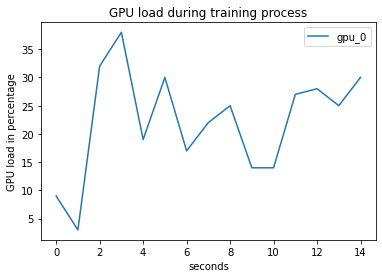

In [21]:
monitor.plot_gpu_usage()

# MNIST with 2 GPUs, 16 vCPU

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 185.46 secs | Loss: 0.5732 | Train Acc: 0.4089 | Test Acc: 0.5943
Epoch 2/50 in 1.55 secs | Loss: 0.5682 | Train Acc: 0.6283 | Test Acc: 0.6481
Epoch 3/50 in 1.52 secs | Loss: 0.5601 | Train Acc: 0.6533 | Test Acc: 0.6552
Epoch 4/50 in 1.47 secs | Loss: 0.5476 | Train Acc: 0.6606 | Test Acc: 0.6658
Epoch 5/50 in 1.47 secs | Loss: 0.5306 | Train Acc: 0.6808 | Test Acc: 0.6838
Epoch 6/50 in 1.50 secs | Loss: 0.5111 | Train Acc: 0.7046 | Test Acc: 0.7092
Epoch 7/50 in 1.51 secs | Loss: 0.4927 | Train Acc: 0.7325 | Test Acc: 0.7428
Epoch 8/50 in 1.48 secs | Loss: 0.4786 | Train Acc: 0.7607 | Test Acc: 0.7767
Epoch 9/50 in 1.52 secs | Loss: 0.4689 | Train Acc: 0.7855 | Test Acc: 0.7965
Epoch 10/50 in 1.46 secs | Loss: 0.4623 | Train Acc: 0.8020 | Test Acc: 0.8125
Epoch 11/50 in 1.52 secs | Loss: 0.4573 | Train Acc: 0.8142 | Test Acc: 0.8249
Epoch 12/50 in 1.49 secs | Loss: 0.4533 | Train Acc: 0.8234 | T

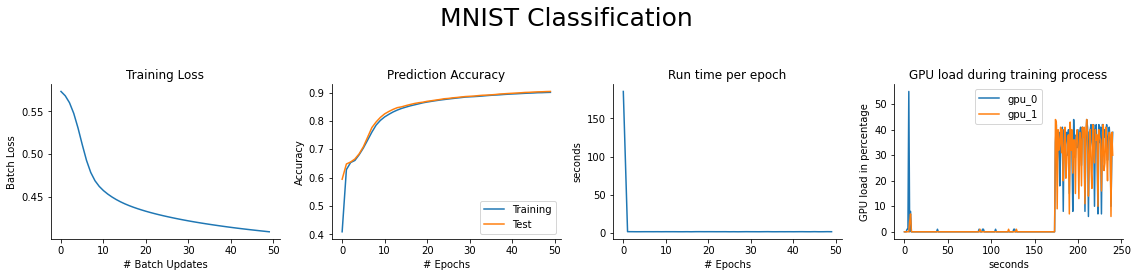

In [15]:
# (First time access on storage from different location)
batch_size = 32
monitor = Monitor(1)
train()

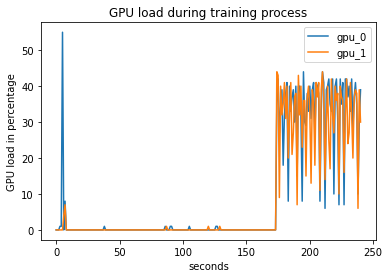

In [16]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 2.55 secs | Loss: 0.5725 | Train Acc: 0.4290 | Test Acc: 0.6120
Epoch 2/50 in 1.56 secs | Loss: 0.5667 | Train Acc: 0.6454 | Test Acc: 0.6573
Epoch 3/50 in 1.57 secs | Loss: 0.5575 | Train Acc: 0.6628 | Test Acc: 0.6587
Epoch 4/50 in 1.51 secs | Loss: 0.5435 | Train Acc: 0.6641 | Test Acc: 0.6668
Epoch 5/50 in 1.56 secs | Loss: 0.5251 | Train Acc: 0.6800 | Test Acc: 0.6890
Epoch 6/50 in 1.59 secs | Loss: 0.5043 | Train Acc: 0.7017 | Test Acc: 0.7134
Epoch 7/50 in 1.51 secs | Loss: 0.4844 | Train Acc: 0.7304 | Test Acc: 0.7460
Epoch 8/50 in 1.54 secs | Loss: 0.4681 | Train Acc: 0.7628 | Test Acc: 0.7753
Epoch 9/50 in 1.49 secs | Loss: 0.4560 | Train Acc: 0.7878 | Test Acc: 0.7980
Epoch 10/50 in 1.54 secs | Loss: 0.4474 | Train Acc: 0.8040 | Test Acc: 0.8112
Epoch 11/50 in 1.60 secs | Loss: 0.4410 | Train Acc: 0.8155 | Test Acc: 0.8214
Epoch 12/50 in 1.56 secs | Loss: 0.4359 | Train Acc: 0.8260 | Tes

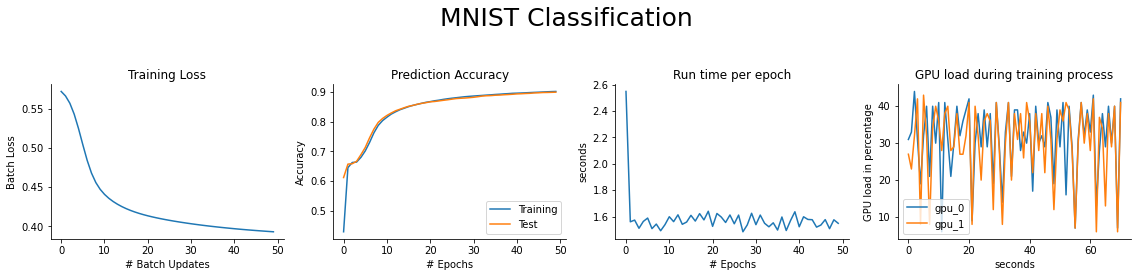

In [21]:
batch_size = 32
monitor = Monitor(1)
train()

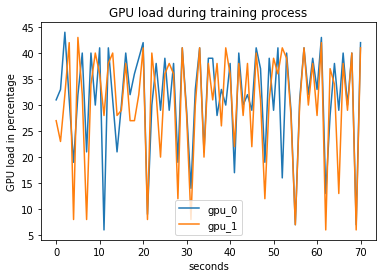

In [22]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 2.39 secs | Loss: 0.5732 | Train Acc: 0.4138 | Test Acc: 0.6007
Epoch 2/50 in 1.48 secs | Loss: 0.5679 | Train Acc: 0.6312 | Test Acc: 0.6464
Epoch 3/50 in 1.49 secs | Loss: 0.5594 | Train Acc: 0.6494 | Test Acc: 0.6466
Epoch 4/50 in 1.55 secs | Loss: 0.5466 | Train Acc: 0.6541 | Test Acc: 0.6593
Epoch 5/50 in 2.78 secs | Loss: 0.5295 | Train Acc: 0.6744 | Test Acc: 0.6853
Epoch 6/50 in 1.53 secs | Loss: 0.5104 | Train Acc: 0.6986 | Test Acc: 0.7120
Epoch 7/50 in 1.50 secs | Loss: 0.4926 | Train Acc: 0.7286 | Test Acc: 0.7454
Epoch 8/50 in 1.53 secs | Loss: 0.4786 | Train Acc: 0.7626 | Test Acc: 0.7737
Epoch 9/50 in 1.52 secs | Loss: 0.4687 | Train Acc: 0.7885 | Test Acc: 0.7918
Epoch 10/50 in 1.44 secs | Loss: 0.4618 | Train Acc: 0.8051 | Test Acc: 0.8059
Epoch 11/50 in 1.56 secs | Loss: 0.4567 | Train Acc: 0.8173 | Test Acc: 0.8173
Epoch 12/50 in 1.53 secs | Loss: 0.4527 | Train Acc: 0.8268 | Tes

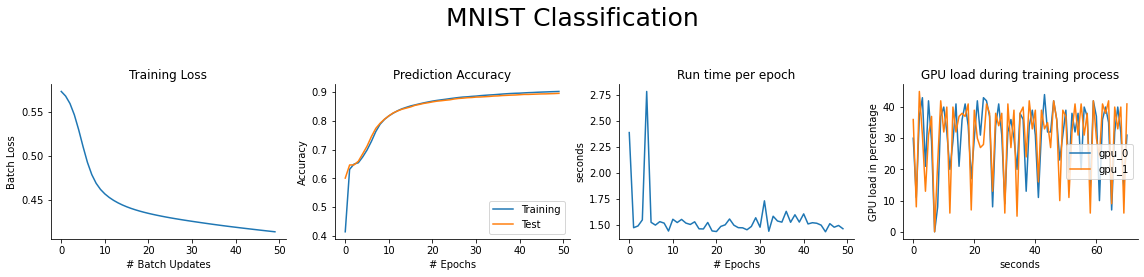

In [17]:
batch_size = 64
monitor = Monitor(1)
train()

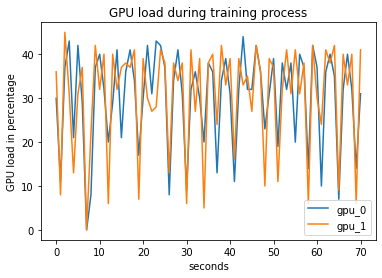

In [18]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 2.34 secs | Loss: 0.5736 | Train Acc: 0.4237 | Test Acc: 0.6161
Epoch 2/50 in 1.50 secs | Loss: 0.5691 | Train Acc: 0.6556 | Test Acc: 0.6710
Epoch 3/50 in 1.50 secs | Loss: 0.5619 | Train Acc: 0.6771 | Test Acc: 0.6764
Epoch 4/50 in 1.60 secs | Loss: 0.5505 | Train Acc: 0.6801 | Test Acc: 0.6867
Epoch 5/50 in 1.48 secs | Loss: 0.5340 | Train Acc: 0.6934 | Test Acc: 0.7006
Epoch 6/50 in 1.59 secs | Loss: 0.5141 | Train Acc: 0.7109 | Test Acc: 0.7197
Epoch 7/50 in 1.44 secs | Loss: 0.4948 | Train Acc: 0.7354 | Test Acc: 0.7480
Epoch 8/50 in 1.49 secs | Loss: 0.4791 | Train Acc: 0.7653 | Test Acc: 0.7759
Epoch 9/50 in 1.55 secs | Loss: 0.4672 | Train Acc: 0.7877 | Test Acc: 0.7941
Epoch 10/50 in 1.56 secs | Loss: 0.4582 | Train Acc: 0.8036 | Test Acc: 0.8084
Epoch 11/50 in 1.50 secs | Loss: 0.4511 | Train Acc: 0.8164 | Test Acc: 0.8182
Epoch 12/50 in 1.52 secs | Loss: 0.4454 | Train Acc: 0.8260 | Tes

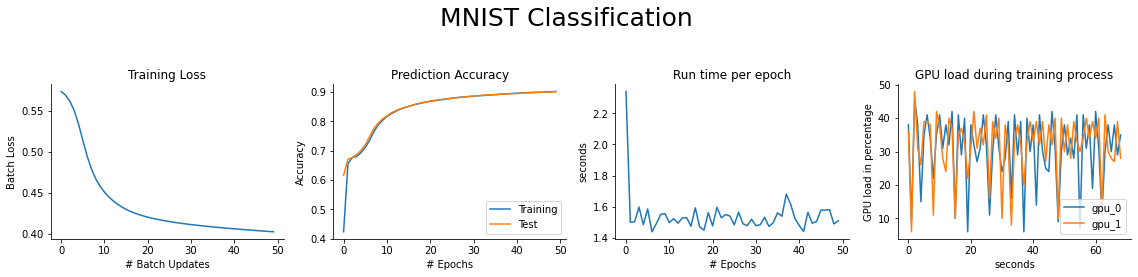

In [19]:
batch_size = 512
monitor = Monitor(1)
train()

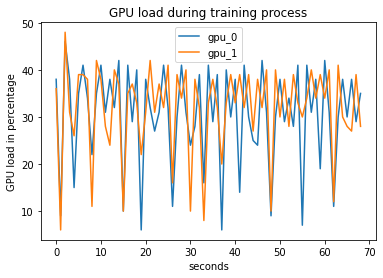

In [20]:
monitor.plot_gpu_usage()

# MNIST with 4 GPUs, 16 vCPUs

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 187.83 secs | Loss: 0.5750 | Train Acc: 0.2880 | Test Acc: 0.4594
Epoch 2/50 in 1.09 secs | Loss: 0.5731 | Train Acc: 0.5484 | Test Acc: 0.5932
Epoch 3/50 in 1.07 secs | Loss: 0.5708 | Train Acc: 0.6225 | Test Acc: 0.6291
Epoch 4/50 in 1.09 secs | Loss: 0.5679 | Train Acc: 0.6429 | Test Acc: 0.6415
Epoch 5/50 in 1.06 secs | Loss: 0.5642 | Train Acc: 0.6459 | Test Acc: 0.6387
Epoch 6/50 in 1.08 secs | Loss: 0.5594 | Train Acc: 0.6450 | Test Acc: 0.6359
Epoch 7/50 in 1.09 secs | Loss: 0.5535 | Train Acc: 0.6449 | Test Acc: 0.6406
Epoch 8/50 in 1.07 secs | Loss: 0.5463 | Train Acc: 0.6503 | Test Acc: 0.6484
Epoch 9/50 in 1.05 secs | Loss: 0.5380 | Train Acc: 0.6603 | Test Acc: 0.6591
Epoch 10/50 in 1.07 secs | Loss: 0.5286 | Train Acc: 0.6715 | Test Acc: 0.6731
Epoch 11/50 in 1.07 secs | Loss: 0.5184 | Train Acc: 0.6841 | Test Acc: 0.6885
Epoch 12/50 in 1.08 secs | Loss: 0.5081 | Train Acc: 0.6983 | T

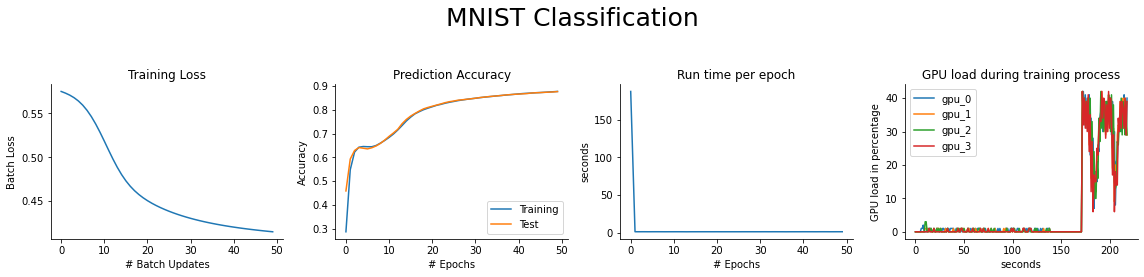

In [26]:
# (First time access on storage from different location)
batch_size = 32
monitor = Monitor(1)
train()

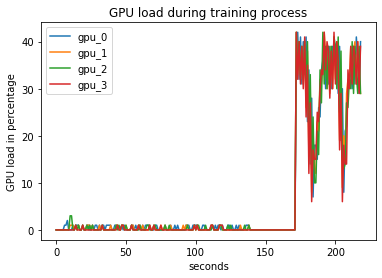

In [27]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 1.87 secs | Loss: 0.5748 | Train Acc: 0.2910 | Test Acc: 0.4599
Epoch 2/50 in 1.10 secs | Loss: 0.5729 | Train Acc: 0.5487 | Test Acc: 0.5985
Epoch 3/50 in 1.13 secs | Loss: 0.5707 | Train Acc: 0.6259 | Test Acc: 0.6443
Epoch 4/50 in 1.11 secs | Loss: 0.5679 | Train Acc: 0.6489 | Test Acc: 0.6562
Epoch 5/50 in 1.09 secs | Loss: 0.5643 | Train Acc: 0.6574 | Test Acc: 0.6599
Epoch 6/50 in 1.08 secs | Loss: 0.5597 | Train Acc: 0.6588 | Test Acc: 0.6620
Epoch 7/50 in 1.08 secs | Loss: 0.5540 | Train Acc: 0.6608 | Test Acc: 0.6657
Epoch 8/50 in 1.08 secs | Loss: 0.5470 | Train Acc: 0.6668 | Test Acc: 0.6736
Epoch 9/50 in 1.07 secs | Loss: 0.5387 | Train Acc: 0.6757 | Test Acc: 0.6834
Epoch 10/50 in 1.07 secs | Loss: 0.5294 | Train Acc: 0.6870 | Test Acc: 0.6940
Epoch 11/50 in 1.07 secs | Loss: 0.5193 | Train Acc: 0.6984 | Test Acc: 0.7055
Epoch 12/50 in 1.08 secs | Loss: 0.5090 | Train Acc: 0.7092 | Tes

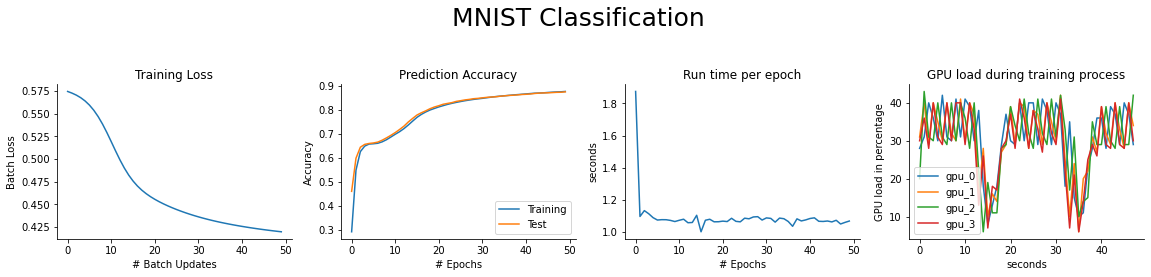

In [28]:
batch_size = 32
monitor = Monitor(1)
train()

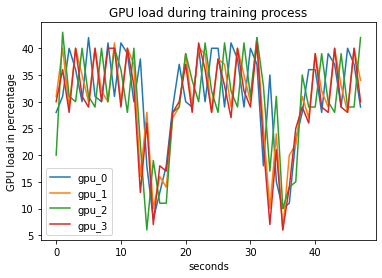

In [29]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 1.88 secs | Loss: 0.5749 | Train Acc: 0.2854 | Test Acc: 0.4519
Epoch 2/50 in 1.08 secs | Loss: 0.5729 | Train Acc: 0.5376 | Test Acc: 0.5911
Epoch 3/50 in 1.10 secs | Loss: 0.5705 | Train Acc: 0.6156 | Test Acc: 0.6364
Epoch 4/50 in 1.12 secs | Loss: 0.5674 | Train Acc: 0.6402 | Test Acc: 0.6504
Epoch 5/50 in 1.06 secs | Loss: 0.5636 | Train Acc: 0.6481 | Test Acc: 0.6553
Epoch 6/50 in 1.12 secs | Loss: 0.5587 | Train Acc: 0.6514 | Test Acc: 0.6589
Epoch 7/50 in 1.11 secs | Loss: 0.5527 | Train Acc: 0.6558 | Test Acc: 0.6640
Epoch 8/50 in 1.07 secs | Loss: 0.5454 | Train Acc: 0.6636 | Test Acc: 0.6736
Epoch 9/50 in 1.08 secs | Loss: 0.5368 | Train Acc: 0.6756 | Test Acc: 0.6861
Epoch 10/50 in 1.08 secs | Loss: 0.5272 | Train Acc: 0.6880 | Test Acc: 0.6990
Epoch 11/50 in 1.07 secs | Loss: 0.5168 | Train Acc: 0.7002 | Test Acc: 0.7126
Epoch 12/50 in 1.09 secs | Loss: 0.5062 | Train Acc: 0.7124 | Tes

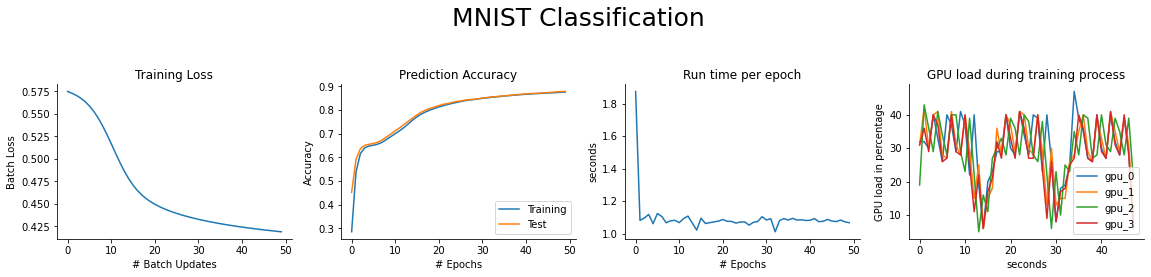

In [30]:
batch_size = 64
monitor = Monitor(1)
train()

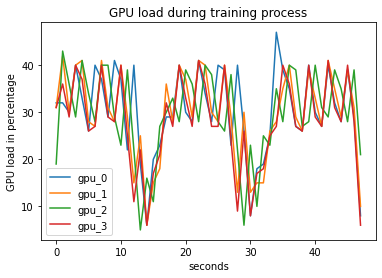

In [31]:
monitor.plot_gpu_usage()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 1.93 secs | Loss: 0.5750 | Train Acc: 0.2901 | Test Acc: 0.4556
Epoch 2/50 in 1.09 secs | Loss: 0.5732 | Train Acc: 0.5432 | Test Acc: 0.5974
Epoch 3/50 in 1.08 secs | Loss: 0.5710 | Train Acc: 0.6192 | Test Acc: 0.6425
Epoch 4/50 in 1.08 secs | Loss: 0.5683 | Train Acc: 0.6438 | Test Acc: 0.6543
Epoch 5/50 in 1.08 secs | Loss: 0.5649 | Train Acc: 0.6517 | Test Acc: 0.6597
Epoch 6/50 in 1.09 secs | Loss: 0.5604 | Train Acc: 0.6541 | Test Acc: 0.6644
Epoch 7/50 in 1.08 secs | Loss: 0.5549 | Train Acc: 0.6566 | Test Acc: 0.6667
Epoch 8/50 in 1.08 secs | Loss: 0.5481 | Train Acc: 0.6629 | Test Acc: 0.6739
Epoch 9/50 in 1.08 secs | Loss: 0.5401 | Train Acc: 0.6732 | Test Acc: 0.6846
Epoch 10/50 in 1.08 secs | Loss: 0.5308 | Train Acc: 0.6872 | Test Acc: 0.6961
Epoch 11/50 in 1.09 secs | Loss: 0.5207 | Train Acc: 0.6985 | Test Acc: 0.7063
Epoch 12/50 in 1.08 secs | Loss: 0.5102 | Train Acc: 0.7102 | Tes

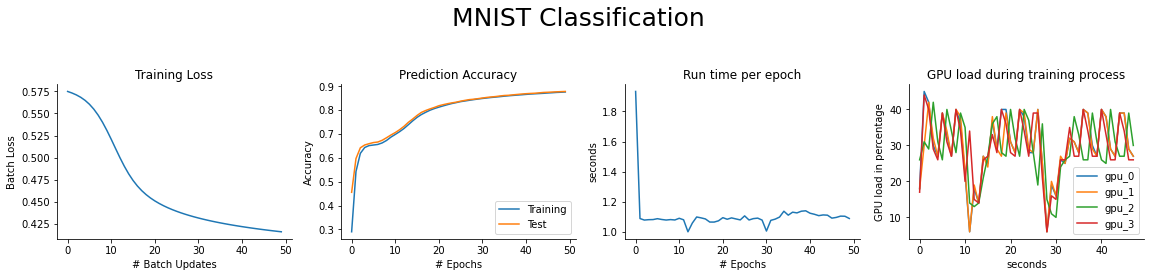

In [32]:
batch_size = 512
monitor = Monitor(1)
train()

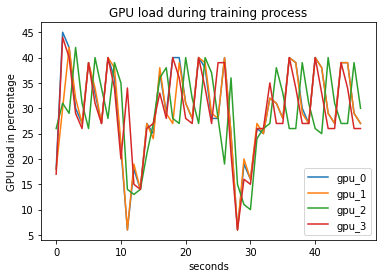

In [33]:
monitor.plot_gpu_usage()

# MNIST with 16 vCPU

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 3.88 secs | Loss: 0.5685 | Train Acc: 0.5279 | Test Acc: 0.6532
Epoch 2/50 in 3.31 secs | Loss: 0.5500 | Train Acc: 0.6596 | Test Acc: 0.6697
Epoch 3/50 in 3.32 secs | Loss: 0.5182 | Train Acc: 0.6924 | Test Acc: 0.7237
Epoch 4/50 in 3.34 secs | Loss: 0.4893 | Train Acc: 0.7487 | Test Acc: 0.7832
Epoch 5/50 in 3.29 secs | Loss: 0.4723 | Train Acc: 0.7968 | Test Acc: 0.8146
Epoch 6/50 in 3.26 secs | Loss: 0.4618 | Train Acc: 0.8221 | Test Acc: 0.8317
Epoch 7/50 in 3.29 secs | Loss: 0.4542 | Train Acc: 0.8385 | Test Acc: 0.8438
Epoch 8/50 in 3.27 secs | Loss: 0.4481 | Train Acc: 0.8488 | Test Acc: 0.8540
Epoch 9/50 in 3.51 secs | Loss: 0.4430 | Train Acc: 0.8567 | Test Acc: 0.8624
Epoch 10/50 in 3.31 secs | Loss: 0.4387 | Train Acc: 0.8635 | Test Acc: 0.8691
Epoch 11/50 in 3.33 secs | Loss: 0.4350 | Train Acc: 0.8682 | Test Acc: 0.8726
Epoch 12/50 in 3.32 secs | Loss: 0.4318 | Train Acc: 0.8738 | Tes

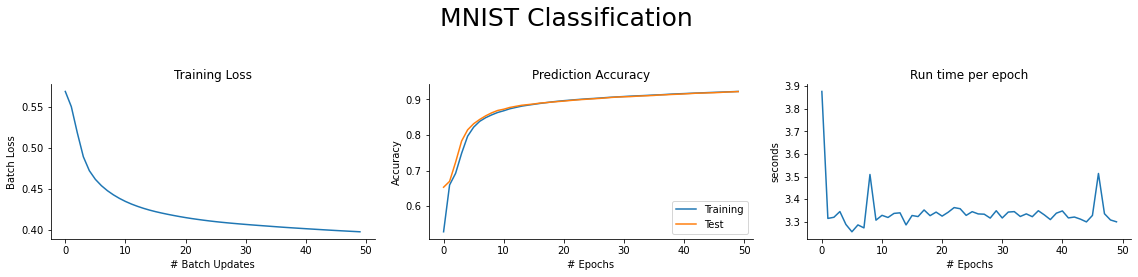

In [22]:
batch_size = 32
train()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 3.76 secs | Loss: 0.5682 | Train Acc: 0.5207 | Test Acc: 0.6424
Epoch 2/50 in 3.25 secs | Loss: 0.5477 | Train Acc: 0.6483 | Test Acc: 0.6589
Epoch 3/50 in 3.26 secs | Loss: 0.5128 | Train Acc: 0.6843 | Test Acc: 0.7111
Epoch 4/50 in 3.25 secs | Loss: 0.4827 | Train Acc: 0.7441 | Test Acc: 0.7741
Epoch 5/50 in 3.24 secs | Loss: 0.4671 | Train Acc: 0.7951 | Test Acc: 0.8069
Epoch 6/50 in 3.26 secs | Loss: 0.4579 | Train Acc: 0.8218 | Test Acc: 0.8288
Epoch 7/50 in 3.23 secs | Loss: 0.4506 | Train Acc: 0.8386 | Test Acc: 0.8411
Epoch 8/50 in 3.24 secs | Loss: 0.4444 | Train Acc: 0.8497 | Test Acc: 0.8507
Epoch 9/50 in 3.22 secs | Loss: 0.4393 | Train Acc: 0.8573 | Test Acc: 0.8587
Epoch 10/50 in 3.20 secs | Loss: 0.4351 | Train Acc: 0.8648 | Test Acc: 0.8647
Epoch 11/50 in 3.22 secs | Loss: 0.4316 | Train Acc: 0.8702 | Test Acc: 0.8705
Epoch 12/50 in 3.22 secs | Loss: 0.4287 | Train Acc: 0.8745 | Tes

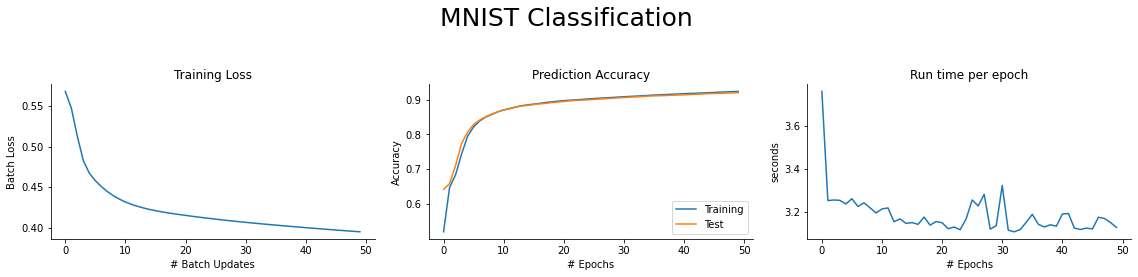

In [23]:
batch_size = 64
train()

Train dataset size: 48000
Val dataset size: 12000
Test dataset size: 10000
Epoch 1/50 in 3.66 secs | Loss: 0.5679 | Train Acc: 0.5414 | Test Acc: 0.6532
Epoch 2/50 in 3.12 secs | Loss: 0.5468 | Train Acc: 0.6670 | Test Acc: 0.6599
Epoch 3/50 in 3.10 secs | Loss: 0.5088 | Train Acc: 0.6921 | Test Acc: 0.7068
Epoch 4/50 in 3.10 secs | Loss: 0.4762 | Train Acc: 0.7462 | Test Acc: 0.7692
Epoch 5/50 in 3.17 secs | Loss: 0.4610 | Train Acc: 0.7955 | Test Acc: 0.8043
Epoch 6/50 in 3.16 secs | Loss: 0.4531 | Train Acc: 0.8215 | Test Acc: 0.8250
Epoch 7/50 in 3.13 secs | Loss: 0.4477 | Train Acc: 0.8373 | Test Acc: 0.8403
Epoch 8/50 in 3.12 secs | Loss: 0.4434 | Train Acc: 0.8487 | Test Acc: 0.8495
Epoch 9/50 in 3.16 secs | Loss: 0.4399 | Train Acc: 0.8576 | Test Acc: 0.8572
Epoch 10/50 in 3.11 secs | Loss: 0.4369 | Train Acc: 0.8644 | Test Acc: 0.8629
Epoch 11/50 in 3.13 secs | Loss: 0.4342 | Train Acc: 0.8697 | Test Acc: 0.8680
Epoch 12/50 in 3.14 secs | Loss: 0.4316 | Train Acc: 0.8740 | Tes

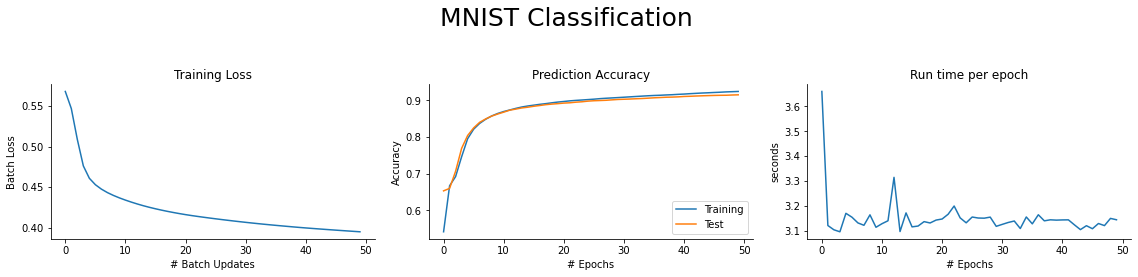

In [24]:
batch_size = 512
train()

# Plot the graph for blog use

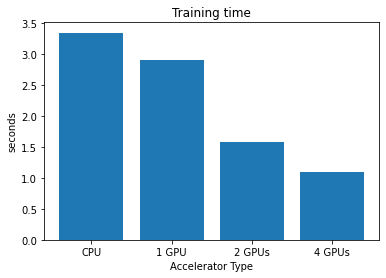

In [3]:
import matplotlib.pyplot as plt
accelerator = ["CPU", "1 GPU", "2 GPUs", "4 GPUs"]
runtime = [3.3424906396865843, 2.898729057312012, 1.583675684928894, 1.0912875175476073]
plt.bar(accelerator, runtime)
plt.xlabel("Accelerator Type")
plt.ylabel("seconds")
plt.title("Training time")
plt.savefig("runtime.png")
plt.show()